# Conda Envrionment install instructions

1. Open anaconda prompt -> cd C:\Users\rs659\Desktop\AIPI 590\Group Project 1\Github Repo
2. Create a folder where you want the env files to be --> mkdir venv
3. conda create --prefix "C:\Users\rs659\Desktop\AIPI 590\Group Project 1\Github Repo\Scene-Recognition\venv" python=3.11.6
4. conda activate "C:\Users\rs659\Desktop\AIPI 590\Group Project 1\Github Repo\Scene-Recognition\venv"
5. conda install -p "C:\Users\rs659\Desktop\AIPI 590\Group Project 1\Github Repo\Scene-Recognition\venv" ipykernel --update-deps --force-reinstall
6. cd Scene-Recognition
7. pip install -r Requirements.txt
8. pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118 

# Data Loader Check

In [ ]:
from dataloader import get_data_loader
import torchvision

train_split = 0.75
full_dataset = torchvision.datasets.ImageFolder(root="Data/")
train_size = int(train_split * len(full_dataset))
test_size = int((len(full_dataset) - train_size)/2)
val_size = len(full_dataset) - train_size - test_size

train_size, test_size, val_size

In [ ]:
train_dataloader, test_dataloader, val_dataloader = get_data_loader(batch_size=64,data_dir="Data/", shuffle=True)
for a in train_dataloader:
    print(a[0].shape, a[1].shape)

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [ ]:
import torch

torch.cuda.is_available()

# Model Training

In [ ]:
# # pip install split-folders

# import splitfolders
# splitfolders.ratio('Data/', output="output", seed=1337, ratio=(.7, 0.15,0.15)) 

In [ ]:
# import packages 
import os 
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.nn as nn

#import your model here
from log import create_logger
from dataloader import get_data_loader, get_data_loader_split
from models.resnet import resnet18
from models.efficientnet import effnet_s
from models.VGG import VGG
from datetime import datetime

# Add your models here
models = {'resnet18': resnet18,
         'enet_s':effnet_s,
         'vgg':VGG
         }

# RUN DETAILS
# run_name = "jly_0206_enets_lr1e-6_bs=64"

now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H%M%S")
run_name = f"run_{timestamp}"

print(run_name)  # Output: run_2024-02-08_143154


model_base = 'enet_s'
num_epochs = 250
bs = 64
lr = 1e-6
random_seed = 42
save_chks = range(num_epochs) # iterable of epochs for which to save the model
use_split = True
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
if device == 'mps':
    torch.mps.empty_cache()

# set up run dir 
run_dir = os.path.join('saved_models', run_name)
os.makedirs(run_dir, exist_ok = True)
log, logclose = create_logger(log_filename=os.path.join(run_dir, 'train.log'), display = False)
log(f'using device: {device}')
log(f'saving models to: {run_dir}')
log(f'using base model: {model_base}')
log(f'using batch size: {bs}')
log(f'learning rate: {lr}')
log(f'random seed: {random_seed}')

# seed randoms and make deterministic
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
# random.seed(random_seed)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

# dataloader
if use_split==True:
    train_dataloader, test_dataloader, val_dataloader = get_data_loader_split(data_dir="output/",  batch_size=bs, shuffle=True)
else:
    train_dataloader, test_dataloader, val_dataloader = get_data_loader(data_dir="Data/",  batch_size=bs, shuffle=True)

# define model 
model = models[model_base]()
model.to(device)

# define optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# training loop
train_loss = []
val_loss = []
test_loss = []
train_metrics = []
val_metrics = []
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    log(f'epoch {epoch}')
    #training
    model.train()
    batch_loss = []
    batch_metric = []
    total_imgs = 0
    for i, (_data, _target) in tqdm(enumerate(train_dataloader)): 
        data = _data.to(device)
        target = _target.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        batch_metric.append(sum(torch.argmax(pred, dim=1)==target).item())
        total_imgs += len(target)
    train_loss.append(sum(np.array(batch_loss)/len(train_dataloader)))
    log(f'\ttrain loss: {train_loss[-1]}')
    train_metrics.append(sum(batch_metric)/total_imgs) #TODO: add metrics
    print(f"Training Metric --- Train Accuracy: {sum(batch_metric)/total_imgs} ---- Train Loss: {sum(np.array(batch_loss)/len(train_dataloader))}")
    del data 
    del target
    del pred
    del loss

    # validation
    total_imgs = 0
    batch_metric = []
    with torch.no_grad():
        model.eval()
        batch_loss = []
        for i, (_data, _target) in tqdm(enumerate(val_dataloader)): 
            data = _data.to(device)
            target = _target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            batch_loss.append(loss.item())
            batch_metric.append(sum(torch.argmax(pred, dim=1)==target).item())
            total_imgs += len(target)
        val_loss.append(sum(np.array(batch_loss)/len(val_dataloader)))
        log(f'\tval loss: {val_loss[-1]}')
        val_metrics.append(sum(batch_metric)/total_imgs) #TODO: add metrics
        print(f"Validation Metric --- Val Accuracy: {sum(batch_metric)/total_imgs} ---- Val Loss: {sum(np.array(batch_loss)/len(val_dataloader))}")


    if epoch in save_chks: 
        torch.save(model.state_dict(), os.path.join(run_dir, f'{epoch}.chkpt'))

    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'loss'))
    plt.close()
    plt.plot(train_metrics, label='train accuracy')
    plt.plot(val_metrics, label='val accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'accu'))
    plt.close()
    del data 
    del target
    del pred
    del loss

    if device == 'mps':
        torch.mps.empty_cache()


# testing
with torch.no_grad():
    model.eval()

In [ ]:
with torch.no_grad():
    model.eval()
    batch_loss = []
    for i, (_data, _target) in tqdm(enumerate(test_dataloader)): 
        data = _data.to(device)
        target = _target.to(device)
        pred = model(data)
        loss = criterion(pred, target)
        batch_loss.append(loss.item())
        batch_metric.append(sum(torch.argmax(pred, dim=1)==target).item()/len(target))
    test_loss.append(sum(np.array(batch_loss)/len(test_dataloader)))
    log(f'\tval loss: {val_loss[-1]}')
    val_metrics.append(np.mean(batch_metric)) #TODO: add metrics

# Predict from images

In [ ]:
# import torch
import PIL as pil





# #load image
# #resize to 224x224
# org_image = pil.Image.open('/Users/rishabhshah/Desktop/AIPI 590/Scene-Recognition/output/test/cathedral/gsun_1a8814d41a9e6565b1b947d8b79c4c39.jpg', mode='r')


# model.predict('/Users/rishabhshah/Desktop/AIPI 590/Scene-Recognition/saved_models/run_2024-02-10_150948/resnet18_full_model_0.pt')


import torchvision.transforms as transforms
import torch



# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485,  0.456,  0.406], std=[0.229,  0.224,  0.225]),
])

# Load and preprocess the image
org_image = pil.Image.open('/Users/rishabhshah/Desktop/AIPI 590/Scene-Recognition/output/test/cathedral/gsun_1a8814d41a9e6565b1b947d8b79c4c39.jpg')
input_tensor = preprocess(org_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

# Perform inference
with torch.no_grad():
    output = model(input_batch.to('mps'))

# Get the predicted class
_, predicted = torch.max(output,  1)
classes = ['Campsite','Candy Store','Canyon','Castle','Cathedral']

print(f'Predicted class: {classes[predicted.item()]}')




# Loading model

In [ ]:
import torch

In [ ]:
# temp_model_path = os.path.join('/tmp', st.session_state.model_file.name)
# with open(temp_model_path, 'wb') as f:
#     f.write(st.session_state.model_file.getvalue())
# Load the model from the temporary path
# model = torch.load(st.session_state.model_path).to('mps')  
# model = torch.load('/Users/rishabhshah/Desktop/AIPI 590/Scene-Recognition/models/saved_models/run_2024-02-11_133708/resnet18_full_model_2.pt').to('mps')
model = torch.load('..\models\saved_models\SEER\seer_regnet32_finetuned_in1k_model_final_checkpoint_phase78.torch')

In [ ]:
# model

In [ ]:
import torch
from PIL import Image
from torchvision import transforms

# Define the transformation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,  0.456,  0.406], std=[0.229,  0.224,  0.225]),
])

# Load the model (make sure the model architecture matches the training)
# model = torch.load('path_to_your_model.pt')
model = torch.load('..\models\saved_models\SEER\seer_regnet32_finetuned_in1k_model_final_checkpoint_phase78.torch')

In [ ]:
model['classy_state_dict']['base_model']['model'].eval()

In [ ]:

model.eval()  # Set the model to evaluation mode

# Load the image
image = Image.open('C:\\Users\\rs659\\Desktop\\AIPI  590\\Group Project  1\\Github Repo\\Scene-Recognition\\data\\raw\\test\\cathedral\\gsun_1a8814d41a9e6565b1b947d8b79c4c39.jpg')
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted = torch.max(output,  1)
print(f'Predicted class: {predicted.item()}')

# Optionally, map the predicted index to class name if you have a mapping
# class_names = ['class1', 'class2', ...]
# print(f'Predicted class: {class_names[predicted.item()]}')

In [ ]:
!python Converter/caffe2pth_convertor.py \
 --prototxt=YOUT_PROTOTXT_PATH \
 --caffemodel=YOUT_CAFFEMODEL_PATH \
 --pthmodel=OUTPUT_PTHMODEL_PATH

In [ ]:
import torch
import caffemodel2pytorch

model = caffemodel2pytorch.Net(
	prototxt = 'deploy_10.prototxt',
	weights = 'snapshot_iter_765280.caffemodel',
	caffe_proto = 'https://raw.githubusercontent.com/BVLC/caffe/master/src/caffe/proto/caffe.proto'
	# caffe_proto = "C:\\Users\\rs659\\Desktop\\AIPI 590\\Group Project 1\\Github Repo\\Scene-Recognition\\Notebooks\\caffe.proto"   
)

In [ ]:
!SET "PATH=%PATH%;%userprofile%\Anaconda2\envs\venv|\Lib\site-packages\torch\bin"

In [ ]:
!protobuf

In [ ]:
!git clone https://github.com/haofanwang/Score-CAM.git

In [ ]:
cd ScoreCam

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models

from utils import *
from cam.scorecam import *

# VGG16
# vgg = models.vgg16(pretrained=True).eval()
# vgg_model_dict = dict(type='vgg16', arch=vgg, layer_name='features_29',input_size=(224, 224))
# vgg_scorecam = ScoreCAM(vgg_model_dict)

model = torch.load('C:\\Users\\rs659\\Desktop\\AIPI 590\\Group Project 1\\Github Repo\\Scene-Recognition\\models\\saved_models\\vgg\\run_2024-02-12_102639\\vgg_best_val_loss_2.pt').eval()
vgg_model_dict = dict(type='vgg16', arch=model, layer_name='features_29',input_size=(224, 224))
vgg_scorecam = ScoreCAM(vgg_model_dict)

input_image = load_image('C:\\Users\\rs659\\Desktop\\AIPI 590\\Group Project 1\\Github Repo\\Scene-Recognition\\data\\raw\\train\\campsite\\gsun_0a1cd2be5ac2a8a7ac765c9625f2c199.jpg')
input_ = apply_transforms(input_image)
if torch.cuda.is_available():
  input_ = input_.cuda()
predicted_class = model(input_).max(1)[-1]

scorecam_map = vgg_scorecam(input_)
with torch.no_grad():
  basic_visualize(input_.cpu(), scorecam_map.type(torch.FloatTensor).cpu())

In [ ]:
cd ScoreCam

In [ ]:
import os
import torch


dir_path = '/Users/rishabhshah/Desktop/AIPI 590/Scene-Recognition/models/saved_models/best_models'

best_model_files = [entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry)) and entry.endswith('.pt')]

In [ ]:
best_model_files

In [ ]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
if device == 'mps':
    torch.mps.empty_cache()

In [ ]:
# dir_path = 'C:\\Users\\rs659\\Desktop\\AIPI 590\\Group Project 1\\Github Repo\\Scene-Recognition\\models\\saved_models\\best_models'

from ScoreCam.utils import *
from ScoreCam.cam.scorecam import *


for model in best_model_files:

    if 'densenet' in model:
        model_name = 'densenet'
        # layer_name = ''
    if 'resnet18' in model:
        model_name = 'resnet'
    if 'vgg' in model:
        model_name = 'vgg'
        layer_name = 'features_29'
    if 'enet_s' in model:
        continue

    model = torch.load(dir_path + '/' + model,  map_location=device).eval()
    vgg_model_dict = dict(type=model_name, arch=model, layer_name='DenseNet_denseblock1',input_size=(224, 224))
    vgg_scorecam = ScoreCAM(vgg_model_dict)

    input_image = load_image('/Users/rishabhshah/Desktop/AIPI 590/Scene-Recognition/data/raw/test/campsite/gsun_1b62d632c3a49e04c7410080aad77c50.jpg')
    input_ = apply_transforms(input_image)
    if torch.cuda.is_available():
        input_ = input_.cuda()
    predicted_class = model(input_).max(1)[-1]

    scorecam_map = vgg_scorecam(input_)
    with torch.no_grad():
        basic_visualize(input_.cpu(), scorecam_map.type(torch.FloatTensor).cpu())

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model = resnet18(pretrained=True).eval()
# Get your input
# img = read_image("path/to/your/image.png")
img = read_image('/Users/rishabhshah/Desktop/AIPI 590/Scene-Recognition/data/raw/test/campsite/gsun_1b62d632c3a49e04c7410080aad77c50.jpg')

# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

with SmoothGradCAMpp(model) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

In [127]:
best_model_files = ['vgg_best_val_loss_42.pt']
#  'densenet_best_val_loss_33.pt',
#  'enet_s_best_val_loss_20.pt']
#  'resnet18_best_val_loss_3.pt']


vgg


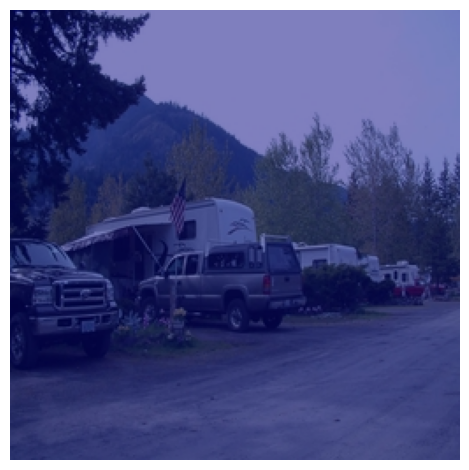

In [128]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask




for model_file_path in best_model_files:


    model = torch.load(dir_path + '/' + model_file_path,  map_location=device)

    for param in model.parameters():
        param.requires_grad = True

    if 'densenet' in model_file_path:
        model_name = 'densenet'
        layer_name = 'features'
    if 'resnet18' in model_file_path:
        model_name = 'resnet'
        layer_name = 'layer4'
    if 'vgg' in model_file_path:
        model_name = 'vgg'
        layer_name = 'features'
    if 'enet_s' in model_file_path:
        model_name = 'enet'
        layer_name = model.features[5]

    print(model_name)
    

    img = read_image('/Users/rishabhshah/Desktop/AIPI 590/Scene-Recognition/data/raw/test/campsite/gsun_1b62d632c3a49e04c7410080aad77c50.jpg')

    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # print(model)
    # with SmoothGradCAMpp(model,layer_name=layer_name) as cam_extractor:
    with SmoothGradCAMpp(model,target_layer=layer_name) as cam_extractor:
        out = model(input_tensor.to(device).unsqueeze(0))
        # Retrieve the CAM by passing the class index and the model output
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    # Display it
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
    

In [111]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [108]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [110]:
# layer_name

In [126]:
# model.MBConv

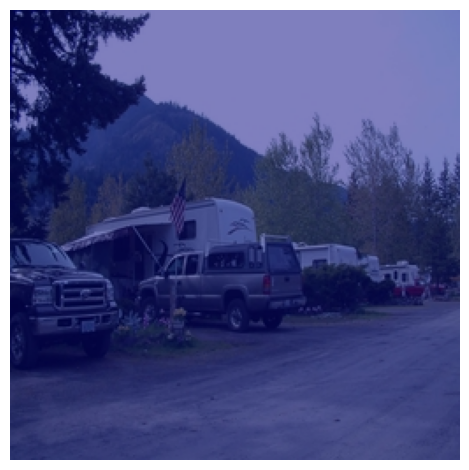

In [138]:

with SmoothGradCAMpp(model) as cam_extractor:
    out = model(input_tensor.to(device).unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)


# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [134]:
model.features[30]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)